In [23]:
import pandas as pd
import json
import numpy as np
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import model_selection,metrics,naive_bayes,preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import RandomOverSampler
stemmer = PorterStemmer()
import warnings
warnings.filterwarnings('ignore')

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [25]:
def clean_data(X):
    STOPWORDS = set(stopwords.words('english'))
    X=X.str.lower()
    X=X.str.replace("[/(){}\[\]\|@,;]", " ")
    X=X.str.replace("[^0-9a-z #+_]", " ")
    X = X.str.replace(r'\d+','')
    X = X.apply(lambda x: ' '.join([w for w in str(x).split() if (len(w)>2 and w not in STOPWORDS) ] ))
    X = X.apply(lambda x: x.split()) 
    return X

def target_arrange(y):
    
    for i in range(len(y)):
        if y.values[i]=='Negative':
            y.values[i]=0.0
        else:
            y.values[i]=1.0
            
    y=y.to_numpy()  
    y=y.reshape(y.shape[0],1)
    y= pd.DataFrame(data=y)
    y=np.ravel(y)
    y=y.astype('float')
    return y

def target_arrange_b(y):
    
    for i in range(len(y)):
        if y.values[i]=='negative':
            y.values[i]=0.0
        else:
            y.values[i]=1.0
            
    y=y.to_numpy()  
    y=y.reshape(y.shape[0],1)
    y= pd.DataFrame(data=y)
    y=np.ravel(y)
    y=y.astype('float')
    return y

In [26]:
with open("All_Tickers.json","r") as fp:
#with open("General_Market.json",encoding='utf8') as fp:
    json_d = json.load(fp)
 
ticks_d = json_d['data']
df = pd.DataFrame(ticks_d)

X= pd.DataFrame(columns=['Date', 'Article','Target'])
X['Date']=pd.to_datetime(df['date'])
X['Article']=df['title']+" "+df['text']
X['Target']=df['sentiment']

indexNames = X[X['Target'] == 'Neutral'].index
 
# Delete these row indexes from dataFrame
X.drop(indexNames , inplace=True)


X=X.sort_values("Date")

print("Number of Examples : ",len(X),"\n")
X.drop_duplicates(inplace=True)
X.index = range(len(X))
print("Number of Examples after removing duplicates: ",len(X),"\n")

print('Number of words before cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
X['Article']=clean_data(X['Article'])
print('Number of words after cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
print("\n******************\n")

X['Target']=target_arrange(X['Target'])
X=X.drop('Date',1)

print("Negative Examples : ",(X['Target']==0).sum())
print("Positive Examples : ",(X['Target']==1).sum())

X['Article']= X['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(X['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
    X['Article'][i] = ' '.join(X['Article'][i])



Test_pd = pd.read_csv(r'all-data.csv',sep=",",skiprows=0,header=None,encoding="latin-1")


X_Tweets= pd.DataFrame(columns=['Article','Target'])
X_Tweets['Article']=Test_pd[Test_pd.columns[1]]
X_Tweets['Target']=Test_pd[Test_pd.columns[0]]

indexNames = X_Tweets[X_Tweets['Target'] == 'neutral'].index
# Delete these row indexes from dataFrame
X_Tweets.drop(indexNames , inplace=True)
X_Tweets.drop_duplicates(inplace=True)
X_Tweets.index = range(len(X_Tweets))

X_Tweets['Article']=clean_data(X_Tweets['Article'])
X_Tweets['Target']=target_arrange_b(X_Tweets['Target'])

X_Tweets['Article']= X_Tweets['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(X_Tweets['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
    X_Tweets['Article'][i] = ' '.join(X_Tweets['Article'][i])
    



Number of Examples :  52853 

Number of Examples after removing duplicates:  42271 

Number of words before cleaning :  1443775
Number of words after cleaning :  941674

******************

Negative Examples :  18466
Positive Examples :  23805


In [29]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9,min_df=5)
Xv = tfidf_vectorizer.fit_transform(X['Article'])
Xv2 = tfidf_vectorizer.transform(X_Tweets['Article'])
#Xv2 = tfidf_vectorizer.fit_transform(Xv2.values.astype('U')) 

Xv = pd.DataFrame(Xv.todense())
Xv2 = pd.DataFrame(Xv2.todense())

X_train,dummy,y_train,dummy2 = train_test_split(Xv,X['Target'], test_size=0.01,stratify=X['Target'])
ros = RandomOverSampler()
X_train,y_train = ros.fit_resample(X_train, y_train)
X_test,dummy,y_test,dummy2 = train_test_split(Xv2,X_Tweets['Target'], test_size=0.01,stratify=X_Tweets['Target'])    



## Naive Bayes 


Metrics

 Recall metric: 0.7339178531849431
 F1 metric: 0.7078412027249236
 Precision metric: 0.7041244161367998
 Accuracy metric: 0.7293271700051361
 Balanced Accuracy metric: 0.7339178531849431 

**************************************************

Normalized confusion matrix
[[0.746 0.254]
 [0.278 0.722]]


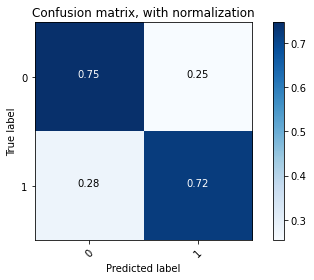

In [30]:
alpha = 0.2 # This is the smoothing parameter for Laplace/Lidstone smoothing
model = naive_bayes.MultinomialNB(alpha=alpha)

model.fit(X_train,y_train)
y_predicted = model.predict(X_test)

print("\nMetrics\n")
recall = metrics.recall_score(y_test,y_predicted,average='macro')
precision = metrics.precision_score(y_test,y_predicted,average='macro')
f1 = metrics.f1_score(y_test,y_predicted,average='macro')
Accur=metrics.accuracy_score(y_test,y_predicted)
B_Accur=metrics.balanced_accuracy_score(y_test,y_predicted)

print(' Recall metric:',recall)
print(' F1 metric:',f1)
print(' Precision metric:',precision)
print(' Accuracy metric:',Accur)
print(' Balanced Accuracy metric:',B_Accur,"\n")
print("**************************************************\n")

cnf_matrix = confusion_matrix(y_test, y_predicted,labels=[0, 1])
np.set_printoptions(precision=3)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                  title='Confusion matrix, with normalization')


## Random Forest


Metrics with OverSampling

 Recall metric: 0.7207283482624314
 F1 metric: 0.7274423908882542
 Precision metric: 0.7368173258003767
 Accuracy metric: 0.7755521314843349
 Balanced Accuracy metric: 0.7207283482624314 

**************************************************

Normalized confusion matrix
[[0.579 0.421]
 [0.137 0.863]]


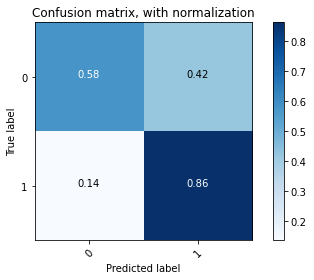

In [33]:
model2 = RandomForestClassifier(n_estimators=30, max_features="auto", n_jobs=-1)
model2.fit(X_train,y_train)
y_predicted = model2.predict(X_test)

print("\nMetrics with OverSampling\n")
recall = metrics.recall_score(y_test,y_predicted,average='macro')
precision = metrics.precision_score(y_test,y_predicted,average='macro')
f1 = metrics.f1_score(y_test,y_predicted,average='macro')
Accur=metrics.accuracy_score(y_test,y_predicted)
B_Accur=metrics.balanced_accuracy_score(y_test,y_predicted)

print(' Recall metric:',recall)
print(' F1 metric:',f1)
print(' Precision metric:',precision)
print(' Accuracy metric:',Accur)
print(' Balanced Accuracy metric:',B_Accur,"\n")
print("**************************************************\n")

cnf_matrix = confusion_matrix(y_test, y_predicted,labels=[0, 1])
np.set_printoptions(precision=3)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                  title='Confusion matrix, with normalization')